In [65]:
# Seed data

N = 21
r = np.array([10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0, 3, 22, 15, 32, 3])
n = np.array([39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7])
x_1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
x_2 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


# Seed Init
alpha_0 = 0
alpha_1 = 0
alpha_2 = 0
alpha_12 = 0
tau = 10
b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0]


In [32]:
import numpy as np
import scipy.stats as stats

In [ ]:
##Brouilllon gibbs sampler

def seeds(nchain, data, prop_sd, init):
    chain = np.zeros((nchain + 1, 5))
    chain[0,:] = init
    acc_rates = np.zeros(5)
    ##Colonne:alpha_0 ,alpha_1,alpha_2 ,alpha_12 ,tau 
    
    alpha_0 ,alpha_1,alpha_2 ,alpha_12 ,tau = hyper_param
    ###Recupere les hyperparamatres
    
    ##Iteration
    for iteration in range(nchain):
        alpha_0 ,alpha_1,alpha_2 ,alpha_12 ,tau = chain[iteration,:]
        
        
        ## Mise à jour de alpha0
        prop= 
        
        top=
        
        bottom=
        
        acc_prob=
        
        ## Mise à jour de alpha1
        prop=
        
        top=
        
        bottom=
        
        acc_prob=
        
        ## Mise à jour de alpha2
        prop=
        
        top=
        
        bottom=
        
        acc_prob=
        
        ## Mise à jour de alpha12
        prop=
        
        top=
        
        bottom=
        
        acc_prob=

        ## Mise à jour de tau
        prop=
        
        top=
        
        bottom=
        
        acc_prob=

In [66]:
####Rien a voir tentative de faire le même modele que celui sur R
def sigmoid(x):
    return 1/(1+np.exp(-x))


def model(r, x1, x2, n, n_iter=2000, burn_in=1000):
    ###Initialisation
    N = len(r)
    alpha0 = 0
    alpha1 = 0
    alpha2 = 0
    alpha12 = 0
    tau = 10
    sigma=1/tau
    b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0]

    p = np.zeros(N)
    
    for i in range(N):
        p[i] = np.random.binomial(n=n[i], p=0.5)        # Echantillonage

        
    # Boucle principale
    for j in range(n_iter):
        b = np.random.normal(loc=0.0, scale=sigma, size=N)        # Echantillonnage des erreurs aléatoires

        for i in range(N):
            w = alpha0 + alpha1 * x1[i] + alpha2 * x2[i] + alpha12 * x1[i] * x2[i] + b[i]
            p[i] = np.random.binomial(n=n[i], p=sigmoid(w))

        alpha0 = np.random.normal(loc=np.mean(p - alpha1 * x1 - alpha2 * x2 - alpha12 * x1 * x2 - b),
                                scale=sigma / np.sqrt(N))
        alpha1 = np.random.normal(loc=np.mean((p - alpha0 - alpha2 * x2 - alpha12 * x1 * x2) * x1),
                                scale=sigma / np.sqrt(np.sum(x1 ** 2)))
        alpha2 = np.random.normal(loc=np.mean((p - alpha0 - alpha1 * x1 - alpha12 * x1 * x2) * x2),
                                scale=sigma / np.sqrt(np.sum(x2 ** 2)))
        alpha12 = np.random.normal(loc=np.mean((p - alpha0 - alpha1 * x1 - alpha2 * x2) * x1 * x2),
                                 scale=sigma / np.sqrt(np.sum(x1 ** 2 * x2 ** 2)))
        tau = np.random.gamma.rvs(a=0.001 + N / 2, scale=1 / (0.001 + np.sum(b ** 2) / 2))
        sigma = 1 / np.sqrt(tau)

    alpha0_samples = np.zeros(n_iter - burn_in)
    alpha1_samples = np.zeros(n_iter - burn_in)
    alpha2_samples = np.zeros(n_iter - burn_in)
    alpha12_samples = np.zeros(n_iter - burn_in)
    tau_samples = np.zeros(n_iter - burn_in)
    for i in range(burn_in, n_iter):
        b = np.random.normal(loc=0.0, scale=sigma, size=N)
        for j in range(N):
            w = alpha0 + alpha1 * x1[j] + alpha2 * x2[j] + alpha12 * x1[j] * x2[j] + b[j]
            p[j] = np.random.binomial(n=n[j], p=sigmoid(w))

        alpha0_samples[i - burn_in] = alpha0
        alpha1_samples[i - burn_in] = alpha1
        alpha2_samples[i - burn_in] = alpha2
        alpha12_samples[i - burn_in] = alpha12
        tau_samples[i - burn_in] = tau

    return {'alpha0': alpha0_samples, 'alpha1': alpha1_samples, 'alpha2': alpha2_samples,
        'alpha12': alpha12_samples, 'tau': tau_samples}

In [67]:
model(r, x_1, x_2, n, n_iter=2000, burn_in=1000)

AttributeError: 'builtin_function_or_method' object has no attribute 'rvs'

In [34]:
x1.shape

(21,)

## Tentative de metropolis hastings

Défini une fonction log_posterior qui calcule la probabilité log-posterior pour le modèle. Cette fonction prend en entrée les valeurs des paramètres alpha0, alpha1, alpha2, alpha12, tau, ainsi que les données r, n, x1, x2 et N. La fonction tire d'abord un échantillon de b d'une distribution normale de moyenne 0 et d'écart-type sqrt(tau),calcule ensuite la probabilité p de succès pour chaque observation, sur la base du modèle de régression logistique , ensuite on calcule la log-vraisemblance et la log-priorité, et je renvoie leur somme, qui est la probabilité log-postérieure




In [68]:
def log_posterior(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, N):
    b = np.random.normal(0.0, np.sqrt(tau), N)
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.exp(alpha0 + alpha1 * x1[i] + alpha2 * x2[i] +
                      alpha12 * x1[i] * x2[i] + b[i]) / (1 + np.exp(alpha0 + alpha1 * x1[i] + alpha2 * x2[i] +
                      alpha12 * x1[i] * x2[i] + b[i]))
    log_likelihood = np.sum(np.log(p) * r + np.log(1 - p) * (n - r))
    log_prior = -0.5 * np.log(tau) - 0.5 * tau
    return log_likelihood + log_prior

Fonction pour metropolis hastings

In [69]:
def metropolis_hastings(initial_values, iterations, proposal_sd, r, n, x1, x2, N):
    # Initialisation
    alpha0, alpha1, alpha2, alpha12, tau = initial_values
    accepted_values = np.zeros((iterations, 5))
    
    for i in range(iterations):
        # Propose une nouvelle valeur avec la loi normale
        proposed_values = np.random.normal([alpha0, alpha1, alpha2, alpha12, tau], proposal_sd)
        
        # Calcul la proba d'acpetation
        log_acceptance_ratio = log_posterior(proposed_values[0], proposed_values[1], proposed_values[2],proposed_values[3], proposed_values[4], r, n, x1, x2, N) - log_posterior(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, N)
        
        #
        u = np.log(np.random.uniform())
        
        # Test pour accepte la proposition
        if u < log_acceptance_ratio:
            alpha0, alpha1, alpha2, alpha12, tau = proposed_values
            accepted_values[i,:] = proposed_values
        else:
            accepted_values[i,:] = [alpha0, alpha1, alpha2, alpha12, tau]
    
    return accepted_values


In [70]:
init = [alpha_0,alpha_1, alpha_2, alpha_12,tau]
iterations = 1000
proposal_sd = [0.1, 0.1, 0.1, 0.1, 0.1]

accepted_values = metropolis_hastings(initial_values, iterations, proposal_sd, r, n, x1, x2, N)

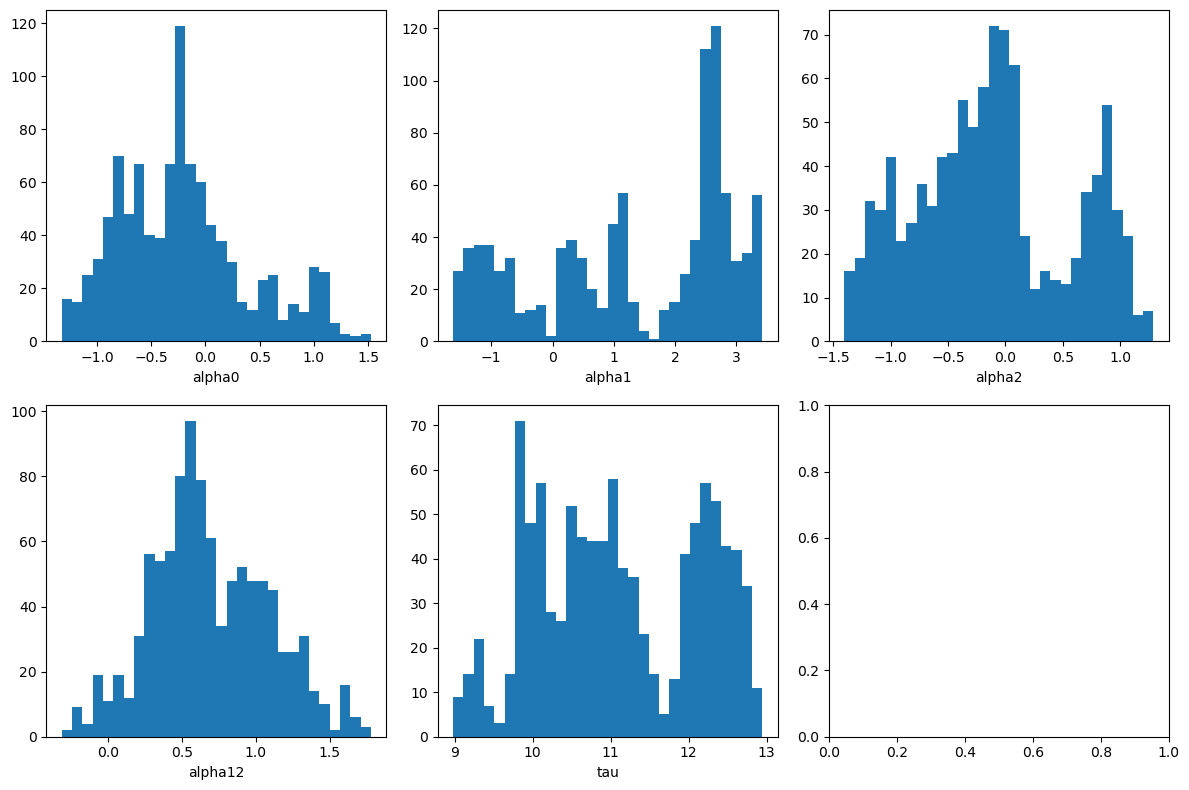

In [71]:
import matplotlib.pyplot as plt

#Distribution des paramètres
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[0, 0].hist(accepted_values[:, 0], bins=30)
axs[0, 0].set_xlabel('alpha0')
axs[0, 1].hist(accepted_values[:, 1], bins=30)
axs[0, 1].set_xlabel('alpha1')
axs[0, 2].hist(accepted_values[:, 2], bins=30)
axs[0, 2].set_xlabel('alpha2')
axs[1, 0].hist(accepted_values[:, 3], bins=30)
axs[1, 0].set_xlabel('alpha12')
axs[1, 1].hist(accepted_values[:, 4], bins=30)
axs[1, 1].set_xlabel('tau')
plt.tight_layout()
plt.show()